In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime

In [17]:
def parser(x):
	return pd.datetime.strptime('198'+x, '%Y-%m')

In [18]:
dataset = pd.read_csv('/content/drive/My Drive/Datasets/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


In [19]:
dataset.head()

Month
1981-01-01    266.0
1981-02-01    145.9
1981-03-01    183.1
1981-04-01    119.3
1981-05-01    180.3
Name: Sales, dtype: float64

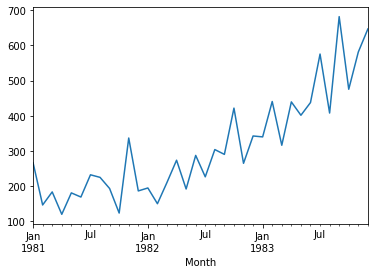

In [20]:
dataset.plot()
plt.show()

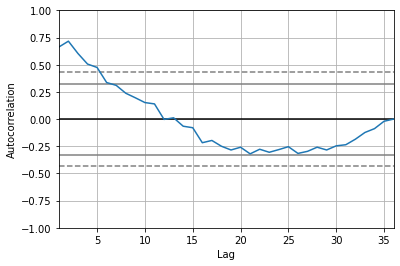

In [21]:
pd.plotting.autocorrelation_plot(dataset)
plt.show()

Terdapat korelasi positif di lag 5, maka kita akan mencoba dengan variabel p = 5

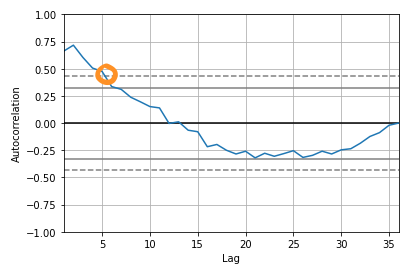

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Auto Correlation Intergrated Moving Average (ARIMA)

Hyperparameters:
  - `p` AR (Autocorrelation): Dipengaruhi oleh suatu jarak waktu (lag)
  - `d` I (Intergrated): Membuat data stationary. Apabila nilai lag besar (asumsi, diatas 10, nilai `d` juga perlu ditambahkan).
  - `q` MA (Moving Average): Memperbaiki hasil prediksi di masa depan berdasarkan prediksi sekarang (dihitung perbedaan/residual errornya). Dikenal juga sebagai residual error lag.

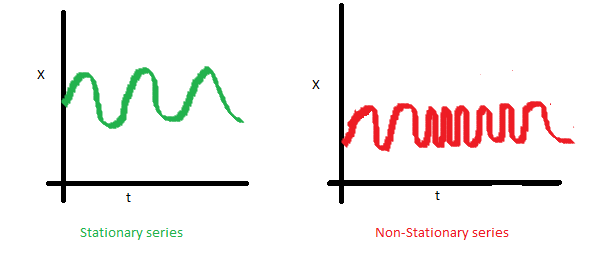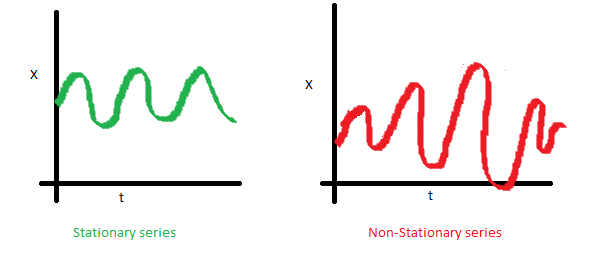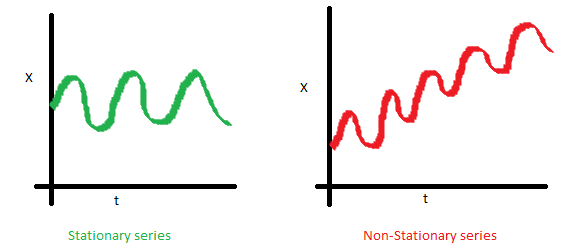

In [23]:
model = ARIMA(dataset, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Wed, 16 Sep 2020   AIC                            406.340
Time:                        14:09:15   BIC                            417.227
Sample:                    02-01-1981   HQIC                           410.098
                         - 12-01-1983                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003       4.908      19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000      -1.466      -0.750
ar.L2.D.Sales    -0.6203      0.282     

`residual error = expected - predicted`

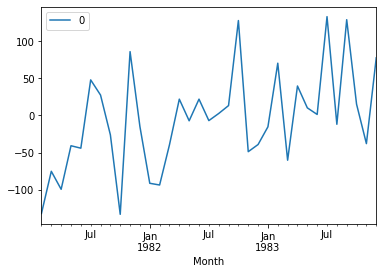

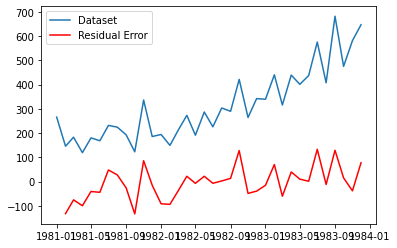

In [24]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

plt.plot(dataset)
plt.plot(residuals,  color='red')
plt.legend(['Dataset','Residual Error'])

In [25]:
residuals

,0
Month,
1981-02-01,-132.164916
1981-03-01,-75.282595
1981-04-01,-99.566786
1981-05-01,-40.831832
1981-06-01,-44.124117
1981-07-01,47.971357
1981-08-01,27.516124
1981-09-01,-26.142078
1981-10-01,-133.296649


In [26]:
print(residuals.describe())

                0
count   35.000000
mean    -5.495267
std     68.132879
min   -133.296649
25%    -42.477975
50%     -7.186677
75%     24.748283
max    133.237923


# Rolling Forecast ARIMA Model (Prediction)

In [27]:
values = dataset.values
size = int(len(values) * 0.66)
train, test = values[0:size], values[size:len(values)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	prediction = output[0]
	predictions.append(prediction)
	expected = test[t]
	history.append(expected)
	print('predicted=%f, expected=%f' % (prediction, expected))
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

predicted=349.117705, expected=342.300000
predicted=306.512977, expected=339.700000
predicted=387.376388, expected=440.400000
predicted=348.154194, expected=315.900000
predicted=386.308770, expected=439.300000
predicted=356.081960, expected=401.300000
predicted=446.379501, expected=437.400000
predicted=394.737276, expected=575.500000
predicted=434.915504, expected=407.600000
predicted=507.923350, expected=682.000000
predicted=435.482832, expected=475.300000
predicted=652.743765, expected=581.300000
predicted=546.343452, expected=646.900000
Test RMSE: 83.417


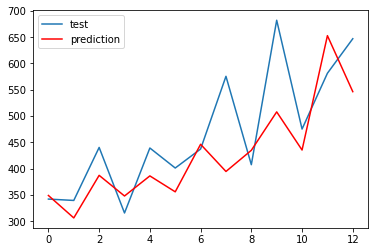

In [28]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test','prediction'])
plt.show()

In [29]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [30]:
import warnings

p_values = range(0, 10)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=52425.268
ARIMA(0, 0, 1) MSE=38145.195
ARIMA(0, 0, 2) MSE=23989.653
ARIMA(0, 1, 0) MSE=18003.173
ARIMA(0, 1, 1) MSE=9558.316
ARIMA(0, 2, 0) MSE=67339.808
ARIMA(0, 2, 1) MSE=18322.501
ARIMA(1, 0, 0) MSE=23113.113
ARIMA(1, 1, 0) MSE=7121.380
ARIMA(1, 1, 1) MSE=7003.684
ARIMA(1, 2, 0) MSE=18608.023
ARIMA(2, 0, 0) MSE=10283.973
ARIMA(2, 1, 0) MSE=5689.927
ARIMA(2, 1, 1) MSE=7759.706
ARIMA(2, 2, 0) MSE=9860.938
ARIMA(3, 0, 0) MSE=9543.274
ARIMA(3, 1, 0) MSE=6998.942
ARIMA(3, 1, 1) MSE=7145.881
ARIMA(3, 2, 0) MSE=10513.286
ARIMA(4, 1, 0) MSE=6649.595
ARIMA(4, 1, 1) MSE=6796.300
ARIMA(4, 2, 0) MSE=7596.334
ARIMA(4, 2, 1) MSE=4694.876
ARIMA(5, 0, 0) MSE=9697.333
ARIMA(5, 1, 0) MSE=6958.325
ARIMA(5, 2, 0) MSE=6710.522
ARIMA(6, 0, 0) MSE=8194.795
ARIMA(6, 1, 0) MSE=6810.075
ARIMA(6, 1, 1) MSE=4435.120
ARIMA(6, 2, 0) MSE=6261.108
ARIMA(7, 0, 0) MSE=7445.265
ARIMA(7, 1, 0) MSE=6523.848
ARIMA(8, 1, 0) MSE=6579.571
ARIMA(9, 1, 0) MSE=7299.586
Best ARIMA(6, 1, 1) MSE=4435.120


# Seasonal Autoregressive Integrated Moving Average (SARIMA)

Hyperparameters:

Order
  - `p` AR (Autocorrelation): Dipengaruhi oleh suatu jarak waktu (lag)
  - `d` I (Intergrated): Membuat data stationary. Apabila nilai lag besar (asumsi, diatas 10, nilai `d` juga perlu ditambahkan).
  - `q` MA (Moving Average): Memperbaiki hasil prediksi di masa depan berdasarkan prediksi sekarang (dihitung perbedaan/residual errornya)

Seasonal order
  - `P`: Seasonal autoregressive order.
  - `D`: Seasonal difference order.
  - `Q`: Seasonal moving average order.
  - `m`: Time steps untuk sebuah seasonal period.
  - `trend`: kecenderungan grafik output terhadap waktu
    - `n`: No trend
    - `c`: Constant
    - `t`: Linear
    - `ct`: Constant with linear trend


https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

No Trend & No Seasonality

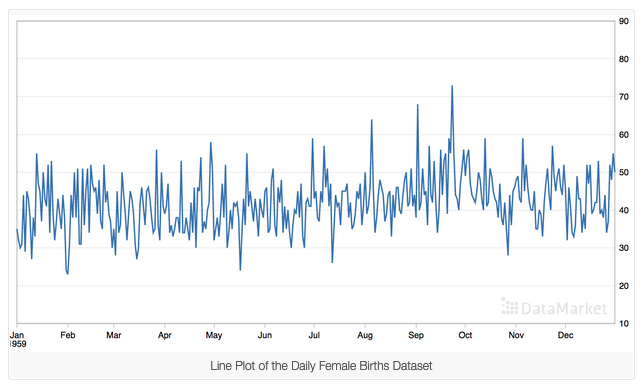

Trend

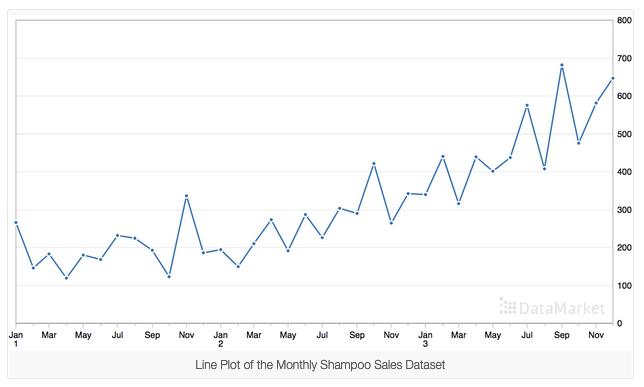

Seasonality

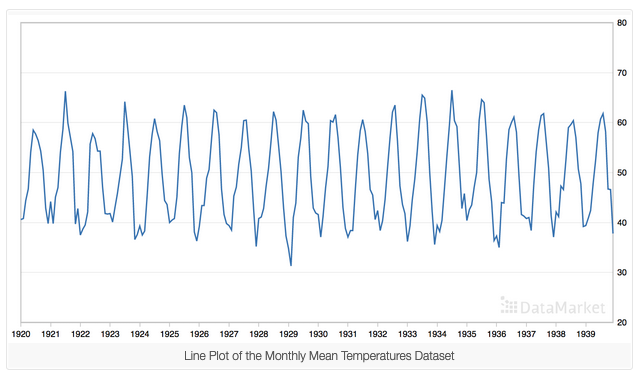

Trend and seasonality

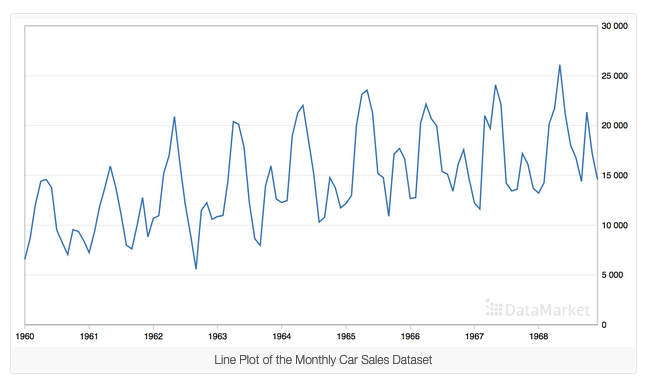

In [31]:
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
# Courtesy of Jason Brownlee of Machine Learning Mastery
# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

In [33]:
n_test = 12

# model configs
cfg_list = sarima_configs()

# grid search
scores = grid_search(dataset, cfg_list, n_test)
print('done')

# list top 3 configs
for cfg, error in scores[:3]:
  print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 491.532
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 328.076
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 144.299
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 264.173
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 84.467
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'n']] 88.757
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'n']] 75.366
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'n']] 72.974
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 235.880
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'n']] 74.027
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 198.046
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 154.445
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'c']] 158.740
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'c']] 121.533
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'c']] 162.828
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'c']] 98.034
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'c']] 66.781
 > Model[[(0, 0, 0), (0, 0, 0, 0), 't']] 81.900
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'c']] 150.345
 > Model[[(0, 0, 0), (0, 0, 1, 0), 't']] 87.885
 > Model[[(0, 0, 0), (1, 0, 0

# Assignment

Untuk dataset sales dan birth:

1. Plot dataset yang digunakan

2. Tentukan apakah dataset yang digunakan terdapat **trend dan atau seasonality**!

3. Nilai hyperparameter untuk ARIMA terbaik beserta nilai RMSEnya. Jelaskan untuk masing-masing hyperparameter!

4. Nilai hyperparameter untuk SARIMA terbaik beserta nilai RMSEnya. Jelaskan untuk masing-masing hyperparameter!

5. Bandingkan nilai RMSE tertinggi dari ARIMA & SARIMA, lalu simpulkan!

